In [1]:
from mermin_benchmarking import *
import json
import numpy as np
import matplotlib.pyplot as plt

from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder, QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [2]:
directory = './data/'
index_path = './data/experiments_index.json'
data = load_mermin_values(directory)
mitigated_data = load_mermin_values(directory, index_path)
# To access ibm_sherbrooke_static, 3q data:
print(data['ibm_sherbrooke']['static']['3q'])

# To access ibm_kyiv_static, 5q data:
print(data['ibm_kyiv']['static']['5q'])


[3.80078125, 3.62890625, 3.748046875]
[14.2890625, 14.390625, 13.9765625]


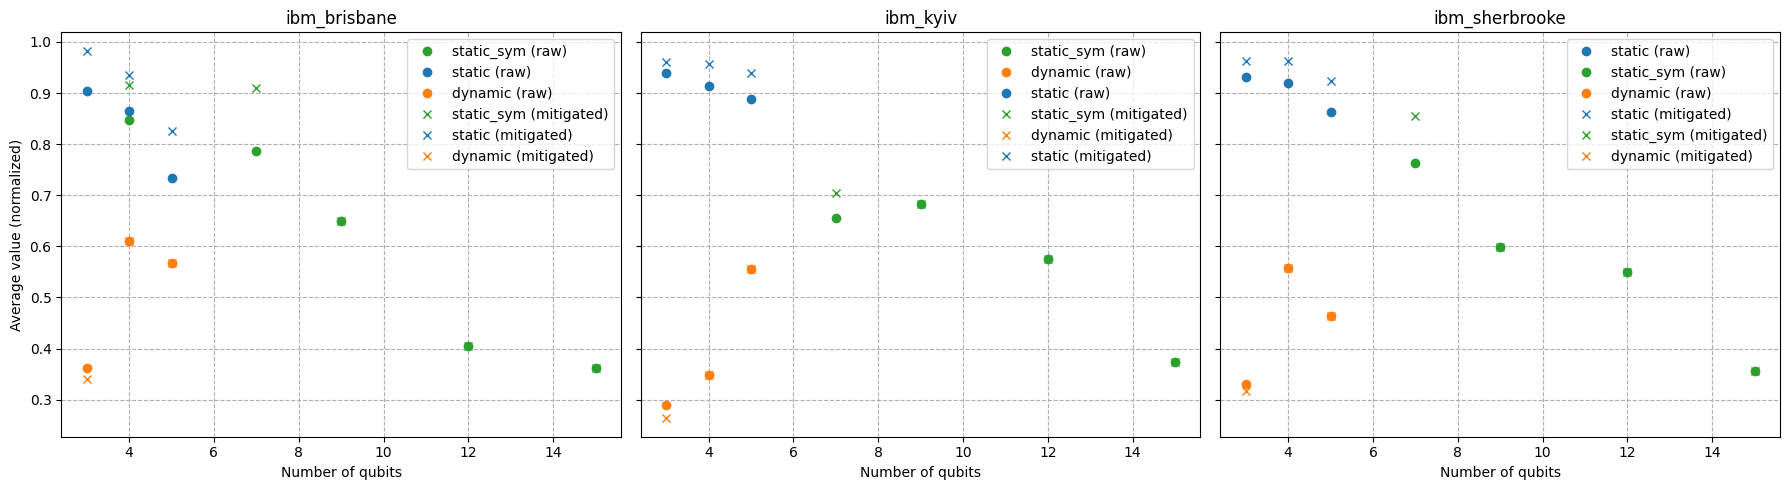

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

colors = {
    'static': 'tab:blue',
    'static_sym': 'tab:green',
    'dynamic': 'tab:orange'
}

markers = {
    'data': 'o',
    'mitigated_data': 'x'
}

datasets = {
    'data': data,
    'mitigated_data': mitigated_data
}

for ax, backend in zip(axes, data.keys()):
    for dataset_name, dataset in datasets.items():
        backend_data = dataset[backend]
        
        for experiment_type, qubit_data in backend_data.items():
            qubits = []
            averages = []

            for num_qubits, values in qubit_data.items():
                qubit_num = int(num_qubits.replace('q', ''))
                qubits.append(qubit_num)
                averages.append(sum(values) / len(values) / 2**(qubit_num - 1))

            if qubits:
                qubits, averages = zip(*sorted(zip(qubits, averages)))
                label = f"{experiment_type} ({'mitigated' if dataset_name == 'mitigated_data' else 'raw'})"
                ax.plot(qubits, averages,
                        marker=markers[dataset_name],
                        linestyle='None',
                        label=label,
                        color=colors.get(experiment_type, 'black'))

    ax.set_title(backend)
    ax.set_xlabel('Number of qubits')
    ax.grid(True, ls='--')
    ax.legend()

axes[0].set_ylabel('Average value (normalized)')
plt.tight_layout()
plt.show()

In [4]:
def parameterized_aspect_circuit(num_qubits, backend=None, physical_qubits=[]):
    qc = QuantumCircuit(2*num_qubits, 2*num_qubits)
    if backend:
        physical_qubits = physical_qubits[:num_qubits]
    qc.compose(GHZ_state(num_qubits, backend, physical_qubits), [i for i in range(num_qubits)], inplace=True)
    
    qc.s(0) # Relative phase |ψ> = 1/sqrt(2) * (|0...> + i |1...>)
    qc.ry(θ,0)
    qc.barrier()
    for i in range(num_qubits, 2*num_qubits):
        qc.h(i)
        qc.measure(i, i)
        with qc.if_test((i, 0)): #X equiv 0
            qc.h(i - num_qubits)
        with qc.if_test((i, 1)): #Y equiv 1
            qc.sdg(i - num_qubits)
            qc.h(i - num_qubits)
        qc.measure(i - num_qubits, i - num_qubits)    

    return qc

θ = Parameter("$\\theta$")
angles = np.linspace(0, 2*np.pi, 21)

circuit = [parameterized_aspect_circuit(num_qubits=2).assign_parameters({θ: ph}) for ph in angles]
sampler = Sampler(mode=AerSimulator())
results = sampler.run(circuit, shots=1024*8).result()
aer_values = [counts2dynamicvalue([res])/2 for res in results]

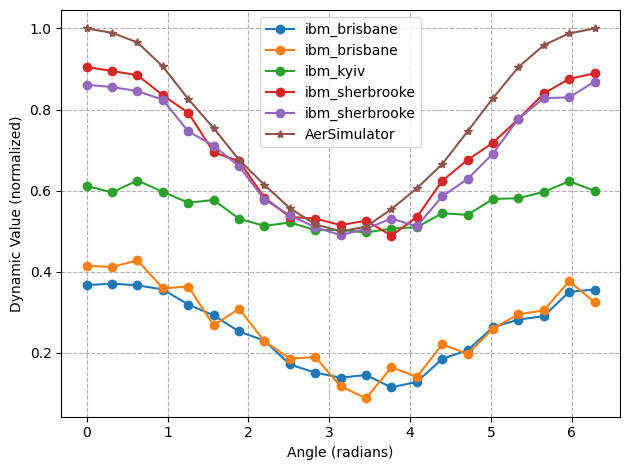

In [5]:
file_paths = ["./data/ibm_brisbane-dynamic_param-2q-20250412221453.json",
              "./data/ibm_brisbane-dynamic_param-2q-20250412213722.json",
              "./data/ibm_kyiv-dynamic_param-2q-20250412223943.json",
              "./data/ibm_sherbrooke-dynamic_param-2q-20250510210355.json",
              "./data/ibm_sherbrooke-dynamic_param-2q-20250510223814.json"
             ]

for file_path in file_paths:
    with open(file_path, "r") as file:
        result = json.load(file, cls=RuntimeDecoder)

    param_values = [counts2dynamicvalue([res])/2 for res in result]

    label = file_path.split("/")[-1].split("-")[0]

    plt.plot(angles, param_values, 'o-', label=label)

plt.plot(angles, aer_values, '*-', label='AerSimulator')
plt.xlabel("Angle (radians)")
plt.ylabel("Dynamic Value (normalized)")
plt.legend()
plt.grid(True, ls='--')
plt.tight_layout()
plt.show()